In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from hmmlearn.hmm import GMMHMM
import preprocessing
import seaborn as sns
from sklearn.model_selection import KFold


class HMMTraining:
    def __init__(self, n_mixtures=3, n_states=5, n_features=12):
        self.class_names = [
                            "chủ", "Về", "Vào", "Tải", "Đầu", "Cuối", "Kế", "Trước", "Dừng", "Ngừng",
                            "Đọc", "Tiếp", "Lui", "Tới", "Tăng", "To", "Giảm", "Nhỏ", "Lại", "Lặp",
                            "Nhanh", "Chậm", "Lưu", "Xóa", "Hủy", "Chạy", "Xong", "Đúng", "Sai", "Giúp",
                            "Giờ", "Ngày", "Tươi", "Có", "Không", "Mục", "Bài", "Một", "Hai", "Ba",
                            "Bốn", "Năm", "Sáu", "Bảy", "Tám", "Chín", "A", "E", "I", "O",
                            "U", "Thổ địa"
                            ]
        self.n_states = n_states
        self.n_mixtures = n_mixtures
        self.dataset_path = './datasets'  # Đường dẫn bộ dữ liệu
        self.n_features = n_features

        self.X = {'train': {}, 'test': {}}
        self.y = {'train': {}, 'test': {}}

        self.models = {}
        self.loss_history = {}
        self.model_path = './models_train'  # Thư mục lưu mô hình

    def preprocess_data(self):
        for cname in self.class_names:
            folder_path = os.path.join(self.dataset_path, cname)
            file_paths = [
                os.path.join(folder_path, file_name)
                for file_name in os.listdir(folder_path)
                if file_name.endswith('.wav')
            ]

            # Xử lý MFCC từ mỗi file
            data = [
                mfcc for file_path in file_paths
                if (mfcc := preprocessing.get_mfcc(file_path, self.n_features)) is not None
            ]
            labels = [self.class_names.index(cname)] * len(data)

            if len(data) == 0:
                print(f"Warning: No valid MFCC data for class {cname}")
                continue

            # Chia dữ liệu thành tập train và test
            x_train, x_test, y_train, y_test = train_test_split(
                data, labels, test_size=0.2, random_state=42
            )

            self.X['train'][cname] = x_train
            self.X['test'][cname] = x_test
            self.y['test'][cname] = y_test

    def train(self):
        self.preprocess_data()

        for cname in self.class_names:
            if cname not in self.X['train'] or len(self.X['train'][cname]) == 0:
                print(f"Skipping training for class {cname}: No training data.")
                continue

            train_data = np.vstack(self.X['train'][cname])
            lengths = [x.shape[0] for x in self.X['train'][cname]]

            model = GMMHMM(
                n_components=self.n_states,
                n_mix=self.n_mixtures,
                covariance_type='diag',
                n_iter=300,
                random_state=42
            )
            model.fit(train_data, lengths)
            self.models[cname] = model

            self.loss_history[cname] = model.monitor_.history

        os.makedirs(self.model_path, exist_ok=True)
        for cname, model in self.models.items():
            model_file = os.path.join(self.model_path, f'model_{cname}_hmm.pkl')
            with open(model_file, 'wb') as f:
                pickle.dump(model, f)

    def predict(self, audio_path):
        # Trích xuất đặc trưng MFCC từ tệp âm thanh
        mfcc = preprocessing.get_mfcc(audio_path, self.n_features)

        if mfcc is None:
            print(f"Không thể trích xuất đặc trưng từ âm thanh: {audio_path}")
            return None

        # Tính toán điểm số cho từng mô hình
        scores = {}
        for cname, model in self.models.items():
            score = model.score(mfcc)  # Tính điểm số cho mô hình của lớp cname
            scores[cname] = score

        # Chọn lớp có điểm số cao nhất
        predicted_class = max(scores, key=scores.get)
        predicted_score = scores[predicted_class]

        print(f"Dự đoán lớp: {predicted_class}, Điểm số: {predicted_score}")
        return predicted_class, predicted_score

    def evaluation(self):
        y_true = []
        y_pred = []

        for cname in self.class_names:
            if cname not in self.X['test']:
                print(f"Skipping evaluation for class {cname}: No test data.")
                continue

            for mfcc, label in zip(self.X['test'][cname], self.y['test'][cname]):
                scores = [model.score(mfcc) for model in self.models.values()]
                pred = np.argmax(scores)
                y_pred.append(pred)
                y_true.append(label)

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        class_accuracy = {}
        for i, cname in enumerate(self.class_names):
            class_accuracy[cname] = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0.0

        return acc, cm, cm_percent, class_accuracy

    def load_models(self):
        model_files = [f for f in os.listdir(self.model_path) if f.endswith('.pkl')]
        
        for model_file in model_files:
            model_path = os.path.join(self.model_path, model_file)
            # Lấy tên lớp từ tên file, bỏ tiền tố 'model_' và hậu tố '_hmm'
            model_name = model_file.replace('model_', '').replace('_hmm.pkl', '')
            try:
                with open(model_path, 'rb') as f:
                    model = pickle.load(f)
                self.models[model_name] = model
                print(f"Tải thành công mô hình: {model_name}")
            except Exception as e:
                print(f"Lỗi khi tải mô hình {model_name}: {e}")


    def plot_loss(self):
        fig, axs = plt.subplots(len(self.loss_history), 1, figsize=(9, len(self.loss_history) * 6))

        for i, (cname, history) in enumerate(self.loss_history.items()):
            axs[i].plot(history, label=f'Log-likelihood ({cname})', color='blue')
            axs[i].set_title(f'Log-likelihood During Training - Class: {cname}')
            axs[i].set_xlabel('Epochs')
            axs[i].set_ylabel('Log-likelihood')
            axs[i].legend()
            axs[i].grid(True)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, cm):
        """
        Vẽ ma trận nhầm lẫn hiển thị số lượng đúng/sai.
        
        Args:
            cm (numpy.ndarray): Ma trận nhầm lẫn.
        """
        plt.figure(figsize=(30, 15))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix (Counts)')
        plt.colorbar()
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        # Ngưỡng để thay đổi màu chữ dựa trên nền
        thresh = cm.max() / 2
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    def predict_dataset(self, dataset_path):
        y_true = []
        y_pred = []

        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if not os.path.isdir(folder_path) or folder_name not in self.class_names:
                print(f"Bỏ qua: {folder_name} (không phải folder hợp lệ hoặc không nằm trong class_names)")
                continue

            true_label = folder_name  # Tên folder là nhãn thực tế
            file_paths = [
                os.path.join(folder_path, file_name)
                for file_name in os.listdir(folder_path)
                if file_name.endswith('.wav')
            ]

            if not file_paths:
                print(f"Folder {folder_name} không chứa file .wav nào.")
                continue

            for file_path in file_paths:
                # Dự đoán lớp
                predicted_class, _ = self.predict(file_path)

                # Đảm bảo chỉ lưu nhãn lớp (không có tiền tố/hậu tố)
                if predicted_class in self.class_names:
                    y_pred.append(predicted_class)
                    y_true.append(true_label)
                else:
                    print(f"Lỗi: {predicted_class} không có trong danh sách class_names.")

        # Chuyển nhãn thành chỉ số để tính ma trận nhầm lẫn
        y_true_indices = [self.class_names.index(label) for label in y_true]
        y_pred_indices = [self.class_names.index(label) for label in y_pred]

        # Tính ma trận nhầm lẫn và độ chính xác
        cm = confusion_matrix(y_true_indices, y_pred_indices)
        acc = accuracy_score(y_true_indices, y_pred_indices)

        # Hiển thị kết quả
        print(f"Accuracy trên tập dữ liệu test: {acc * 100:.2f}%")
        self.plot_confusion_matrix(cm)
    def preprocess_data_all(self):
            for cname in self.class_names:
                folder_path = os.path.join(self.dataset_path, cname)
                file_paths = [
                    os.path.join(folder_path, file_name)
                    for file_name in os.listdir(folder_path)
                    if file_name.endswith('.wav')
                ]

                # Xử lý MFCC từ mỗi file
                data = [
                    mfcc for file_path in file_paths
                    if (mfcc := preprocessing.get_mfcc(file_path, self.n_features)) is not None
                ]

                if len(data) == 0:
                    print(f"Warning: No valid MFCC data for class {cname}")
                    continue

                # Lưu toàn bộ dữ liệu vào self.X và self.y
                self.X[cname] = data
                self.y[cname] = [self.class_names.index(cname)] * len(data)

    def train_all(self):
        self.preprocess_data_all()

        for cname in self.class_names:
            if cname not in self.X or len(self.X[cname]) == 0:
                print(f"Skipping training for class {cname}: No training data.")
                continue

            train_data = np.vstack(self.X[cname])
            lengths = [x.shape[0] for x in self.X[cname]]

            model = GMMHMM(
                n_components=self.n_states,
                n_mix=self.n_mixtures,
                covariance_type='diag',
                n_iter=300,
                random_state=42
            )
            model.fit(train_data, lengths)
            self.models[cname] = model

            self.loss_history[cname] = model.monitor_.history

        os.makedirs(self.model_path, exist_ok=True)
        for cname, model in self.models.items():
            model_file = os.path.join(self.model_path, f'model_{cname}_hmm.pkl')
            with open(model_file, 'wb') as f:
                pickle.dump(model, f)


Tải thành công mô hình: A
Tải thành công mô hình: Ba
Tải thành công mô hình: Bài
Tải thành công mô hình: Bảy
Tải thành công mô hình: Bốn
Tải thành công mô hình: Chín
Tải thành công mô hình: Chạy
Tải thành công mô hình: Chậm
Tải thành công mô hình: chủ
Tải thành công mô hình: Cuối
Tải thành công mô hình: Có
Tải thành công mô hình: Dừng
Tải thành công mô hình: E
Tải thành công mô hình: Giúp
Tải thành công mô hình: Giảm
Tải thành công mô hình: Giờ
Tải thành công mô hình: Hai
Tải thành công mô hình: Hủy
Tải thành công mô hình: I
Tải thành công mô hình: Không
Tải thành công mô hình: Kế
Tải thành công mô hình: Lui
Tải thành công mô hình: Lưu
Tải thành công mô hình: Lại
Tải thành công mô hình: Lặp
Tải thành công mô hình: Một
Tải thành công mô hình: Mục
Tải thành công mô hình: Ngày
Tải thành công mô hình: Ngừng
Tải thành công mô hình: Nhanh
Tải thành công mô hình: Nhỏ
Tải thành công mô hình: Năm
Tải thành công mô hình: O
Tải thành công mô hình: Sai
Tải thành công mô hình: Sáu
Tải thành công mô

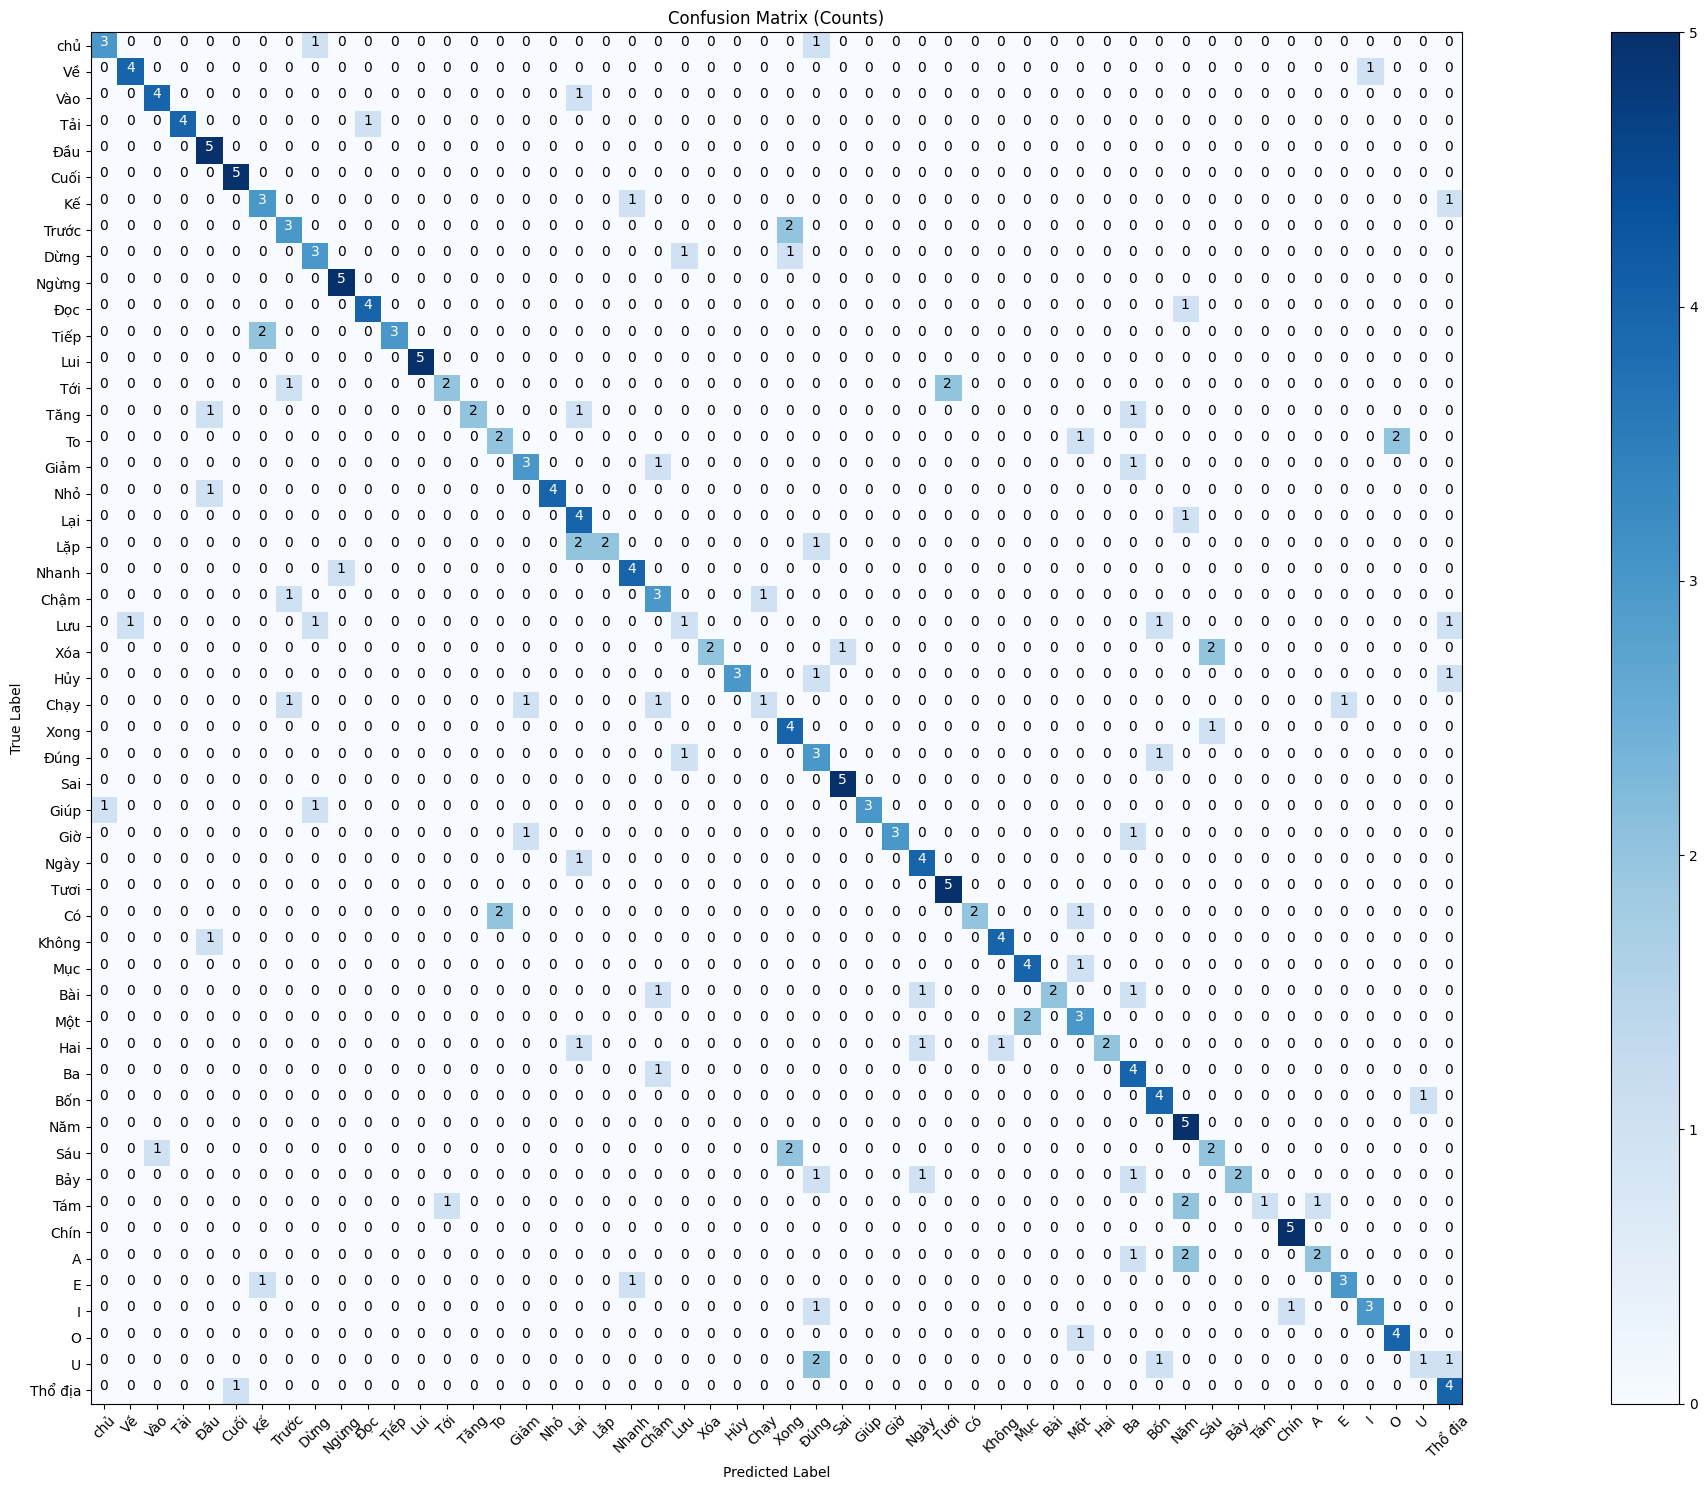

In [5]:
if __name__ == '__main__':
    n_states = 7
    n_mixtures = 3
    n_features = 13

    hmm_train = HMMTraining(n_mixtures=n_mixtures, n_states=n_states, n_features=n_features)
    hmm_train.load_models()  # Tải các mô hình đã huấn luyện

    # Đường dẫn tới thư mục datasets
    dataset_path = './test_new'

    # Dự đoán và đánh giá toàn bộ dữ liệu
    hmm_train.predict_dataset(dataset_path)